# Attack viz

### Background

For a better understanding of the situation, please check the [slides](https://docs.google.com/presentation/d/1oDi0Ds2l3TXghT6AvLKKgyhFA--uFD9d9vGC6eFooss/edit?usp=sharing)  (An epfl authentication is needed to gain access)

Here are the following steps that the attacker take in order to carry on his attack: 
    
    1) Extract the information about the packages that the victim can download by crawling all 
       the metadata in var/lib/   (crawl dir.)
       
    2) Do some cleaning and statistics about the the freshly crawled data. (attack dir.)
    
    3) Capture the victims traffic on updates (for now lab condition) (capture dir.)
    
    4) Match the capture with a specific update (attack dir.)
    
    

We suppose in this notebook that the Attacker already collected/process the following data:
 - `ground_through` : where hypothetically all the packages metadata are up-to-date
 - `gt` : the cleaned version of `ground_truth` processed by the attacker
 - `attack_table` : Containing the capture of the packages that the attacker wants to match
 - `*_old` : old version of the above

 __Please Run Setup before jumping to sections__

### Table of Content <a id = 'tc'></a>

 - [Set Up](#Setup)
 - [Uniqueness investigation & Cleaning ](#cleaning)
 - Mounting an Attack
     - [Relying on HTTP request](#Mounting_an_Attack_HTTP)
     - [Relying only on packages size](#Mounting_an_Attack_SIZE)
     
 - [Dependens discovery](#dependens_discovery)
 - [Gstreamer](#gstreamer)
 - [Kernel Packages](#kernels)
 - [Changement over Time of crawled packages](#time_changement)
 - [Unicity](#unicity)
 - [Signature](#signatures)
 
<a id='Setup'></a>
## Set up 

In [103]:
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import random
from tqdm import tqdm, tqdm_pandas, tqdm_notebook
%matplotlib inline


# Helper function to load a table 
def load_fingerpatch(table, dbname = "fingerpatch"):
    """Load table in the dbname and format it"""
    
    connection = pymysql.connect(host='localhost',
                                 user='fingerpatch',
                                 password='fingerpatch',
                                 db=dbname,
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
    df = pd.read_sql("SELECT * FROM `"+table+"` ",connection)
    connection.close()
    
    if table == "ubuntu_packets":
        df = df.set_index("id")
            
    if table == "ubuntu_cleaned_packets":
        df = df.set_index("id")
        df["Childrens"] = df["Childrens"].map(eval)

            
    if table == "ubuntu_captures":
        df = df.set_index("capture_id")
        df["HTTP_Seq"] = df["HTTP_Seq"].map(eval)
        df["Payload_received"] = df["Payload_received"].map(eval)
        df["Payload_sent"] = df["Payload_sent"].map(eval)
        df["Flows"] = df["Flows"].map(eval)        
        
    return df

<a id='cleaning'></a>
## Uniqueness investigation & Cleaning 

This step is taken by the attacker at the very beginning. Once he crawled the raw packages, he has to clean his data. This is an intermediate step before getting the `gt` dataframe.


Select interesting columns and remove duplicated rows

In [77]:
ground_truth = load_fingerpatch(dbname="fingerpatch", table="ubuntu_packets" )
ground_truth.columns

Index(['capture_id', 'Package', 'Version', 'Architecture', 'Size',
       'Installed-Size', 'Priority', 'Maintainer', 'SHA1', 'Description',
       'parsedFrom', 'Description-md5', 'Bugs', 'Origin', 'MD5sum', 'Depends',
       'Homepage', 'Source', 'SHA256', 'Section', 'Supported', 'Filename',
       'packageMode'],
      dtype='object')

In [78]:
print("Total entries without having cleaned: ", len(ground_truth))

Total entries without having cleaned:  129060


In [79]:
# Selecting only interessting fields i.e. the attacker has no mean to distinguish two packages that have the same size but different packageMode
ground_truth = ground_truth.drop_duplicates(['Package', 'Version', 'Size', 'Depends', 'Architecture'])

# Make sure that there is no duplicate information (For a given Package name and Version we have at most one match)
print("The maximum duplication of rows that have the same Package name and Version is: ", ground_truth.groupby(by=["Package", "Version"]).count()["SHA1"].max())

# Selecting only interessting columns
ground_truth = ground_truth.drop(axis= 1, columns=['capture_id','SHA1', 'Priority', 'Description-md5', 'MD5sum', 'SHA256', 'packageMode' ])

ground_truth = ground_truth.fillna("")
print("Total entries after having cleaned: ", len(ground_truth))

The maximum duplication of rows that have the same Package name and Version is:  1
Total entries after having cleaned:  57125


<a id='Mounting_an_Attack_HTTP'></a>
## Mounting an Attack for matching a specific capture to a package.

[Table of content](#tc)

### Relying on HTTP request
The aim here is to find a match from the attacker's captured HTTP request to the ground_truth database

Let's set the following target we want to match:

In [104]:
gt =load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_cleaned_packets" )
attack_table = load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_captures")
target = attack_table.iloc[1]
target

truth_id                                                        42120
nb_flows                                                            3
HTTP_Seq            [GET /ubuntu/pool/universe/libs/libswingx-java...
Flows               [target->economy.canonical.com, economy.canoni...
Payload_sent                                                 [0, 163]
Payload_received                                            [1444169]
matched                                                             1
Name: 2, dtype: object

In [105]:
target["HTTP_Seq"]

['GET /ubuntu/pool/universe/libs/libswingx-java/libswingx-java_1.6.2-1_all.deb HTTP/1.1']

In [106]:
print("\nAnd we got the following file name in the ground_truth: \n\n",gt.loc[42120]["Filename"] )


And we got the following file name in the ground_truth: 

 pool/universe/libs/libswingx-java/libswingx-java_1.6.2-1_all.deb


Thererfore, we notice that the attribute `Filename` match the HTTP request pretty well, except that, in the HTTP request, the beginning of the root in the url begin with `/ubuntu/` . So if the victim use the pure HTTP protocol, the attacker should be able to match exactly all the package. There are some little issues easy to fix: 

In [107]:
print("In the ground_truth: \n\n",ground_truth.loc[14404]["Filename"])
print("\nIn the attacker's table after having parsed: \n\n", attack_table.loc[32]["HTTP_Seq"][0])

In the ground_truth: 

 pool/universe/f/freepops/freepops-updater-fltk_0.2.9-8_amd64.deb

In the attacker's table after having parsed: 

 GET /ubuntu/pool/main/d/dee/libdee-doc_1.2.7%2b14.04.20140324-0ubuntu1_all.deb HTTP/1.1


Here we see that the HTTP request changes `+` in `%2b`. So we need to parse the HTTP sequence and change it before the matching

In [108]:
def matchHTTP(x, df):
    """
    x String contraining the filename
    To use with a map on the attribute FileName
    """

    requests = x

    match = []
    

    for r in requests:
        s = r.split(" ")[1][8:]
        if len(s) < 20: # With only 20 character we reckon that the request doesn't contain enough information for a perfect match
            continue

        s = s.replace("%2b", "\+")
        found = df[df.Filename.str.contains(s)]
        match += found.index.tolist()

    # remove duplicates
    match = list(set(match))

    return match

attack_table["Http Match"] = attack_table["HTTP_Seq"].map(lambda x: matchHTTP(x, gt))

In [109]:
attack_table[["truth_id", "nb_flows", "Http Match"]].tail()

,truth_id,nb_flows,Http Match
capture_id,,,
28,17242,3,[17242]
29,29129,3,[29129]
30,39206,3,[39206]
31,17242,3,[17242]
32,14404,3,[14404]


We found the perfect match each time we could capture the HTTP Seq.

<a id='Mounting_an_Attack_SIZE'></a>
### Relying on package size

We pick the same target as in the previous section

In [114]:
target = attack_table.loc[32]
target

truth_id                                                        14404
nb_flows                                                            3
HTTP_Seq            [GET /ubuntu/pool/main/d/dee/libdee-doc_1.2.7%...
Flows               [target->yukinko.canonical.com, yukinko.canoni...
Payload_sent                                                 [0, 165]
Payload_received                                              [58743]
matched                                                             0
Http Match                                                    [14404]
Name: 32, dtype: object

In [125]:
EXTRA_SIZE_AVERAGE = 283   # Made from stats about captured packets
EXTRA_SIZE_VARIATION = 5

In [126]:
# When matching with Size
def distance_from_expected_average_size(x, size_to_match):
    return abs(size_to_match - x["Summing dependances"] - (EXTRA_SIZE_AVERAGE * x["Elements involved"]))

gt["dist_from_expected_size"] = gt.apply(lambda x: distance_from_expected_average_size(x, sum(target['Payload_received']) ), axis = 1)

In [132]:
gt.sort_values(by="dist_from_expected_size").head()

,Package,Version,Size,Filename,Summing dependances,Elements involved,Childrens,Frequency,Freq in p,dist_from_expected_size
id,,,,,,,,,,
14404,libdee-doc,1.2.7+14.04.20140324-0ubuntu1,58462,pool/main/d/dee/libdee-doc_1.2.7+14.04.2014032...,58462,1,{14404},1,0,2
49384,python-pyme-doc,1:0.8.1-2build1,58478,pool/universe/p/pyme/python-pyme-doc_0.8.1-2bu...,58478,1,{49384},1,0,18
2516,libmbim-glib-doc,1.6.0-2ubuntu0.1,58366,pool/main/libm/libmbim/libmbim-glib-doc_1.6.0-...,58366,1,{2516},1,0,94
15284,libjarjar-java-doc,1.4+svn142-3,58572,pool/main/j/jarjar/libjarjar-java-doc_1.4+svn1...,58572,1,{15284},1,0,112
33252,libgentlyweb-utils-java,1.5-1,58594,pool/universe/g/gentlyweb-utils/libgentlyweb-u...,58594,1,{33252},6,0,134


The first one is the one.

In [128]:
target

truth_id                                                        14404
nb_flows                                                            3
HTTP_Seq            [GET /ubuntu/pool/main/d/dee/libdee-doc_1.2.7%...
Flows               [target->yukinko.canonical.com, yukinko.canoni...
Payload_sent                                                 [0, 165]
Payload_received                                              [58743]
matched                                                             0
Http Match                                                    [14404]
Name: 32, dtype: object

<a id='dependens_discovery'></a>
## Dependens discovery

[Table of content](#tc)



Let's create an attribute `#Depends` which compute the number of Dependences a specific Package contains
and take a Package that has only one Dependence.

In [163]:
ground_truth =load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_packets" )

ground_truth = ground_truth.fillna("")
ground_truth["#Depends"] = ground_truth["Depends"].map(lambda x: 0 if x == "" else len(x.split(",")))

# Take the smallest packet that have only one Dependences
one_dep_first10 = ground_truth[ground_truth["#Depends"] == 1].sort_values(by = "Size", ascending=True)[:10]
one_dep = one_dep_first10.iloc[0]
one_dep[["Package", "Version", "Depends", "#Depends"]]

Package            readpst
Version     0.6.59-1build1
Depends          pst-utils
#Depends                 1
Name: 51087, dtype: object

Seeking about that depends

In [164]:
ground_truth[ground_truth["Package"] == one_dep["Depends"]].iloc[0][["Package", "Version", "Depends","#Depends", "Size"]]

Package                                             pst-utils
Version                                        0.6.59-1build1
Depends     libc6 (>= 2.14), libgcc1 (>= 1:4.1.1), libgd3 ...
#Depends                                                    7
Size                                                    62092
Name: 18280, dtype: object

Turns out that this Dependens also have its Dependances

#### Once Downloading the package `readpst` we can ideed see that the package doesn't just depends on one single package but many subpackages from that dependance:

On the Docker:

`The following extra packages will be installed:
  fontconfig-config fonts-dejavu-core libfontconfig1 libfreetype6 libgd3
  libglib2.0-0 libglib2.0-data libgsf-1-114 libgsf-1-common libjbig0
  libjpeg-turbo8 libjpeg8 libpst4 libtiff5 libvpx1 libx11-6 libx11-data
  libxau6 libxcb1 libxdmcp6 libxml2 libxpm4 pst-utils sgml-base
  shared-mime-info xml-core`
  
`0 upgraded, 27 newly installed, 0 to remove and 32 not upgraded.
Need to get 5664 kB of archives.`


On the attacker:

`historic =  ['target->danava.canonical.com', 'danava.canonical.com->target', 'target->danava.canonical.com']
server_ip =  ['91.189.88.149', '172.100.0.100', '91.189.88.149']
server_name =  ['danava.canonical.com', 'target', 'danava.canonical.com']
received_Payload =  [5671834]
send_Payload =  [0, 4251]`

So if we calculate with the tipical extra_size for each downloaded package that we get on the attacker side and knowing that 5664kB is rounded:


In [161]:
EXTRA_SIZE_AVERAGE * 27 + 5664000

5671641

#### Let's find out what happens if we download the dependance before  

While downloading pst-utils (*using apt-get install readpst*):

On the victim:

`The following extra packages will be installed:
  fontconfig-config fonts-dejavu-core libfontconfig1 libfreetype6 libgd3
  libglib2.0-0 libglib2.0-data libgsf-1-114 libgsf-1-common libjbig0
  libjpeg-turbo8 libjpeg8 libpst4 libtiff5 libvpx1 libx11-6 libx11-data
  libxau6 libxcb1 libxdmcp6 libxml2 libxpm4 sgml-base shared-mime-info
  xml-core
0 upgraded, 26 newly installed, 0 to remove and 32 not upgraded.
Need to get 5663 kB of archives.`


On the Attacker:

`historic =  ['target->keeton.canonical.com', 'keeton.canonical.com->target', 'target->keeton.canonical.com']
server_ip =  ['91.189.88.161', '172.100.0.100', '91.189.88.161']
server_name =  ['keeton.canonical.com', 'target', 'keeton.canonical.com']
received_Payload =  [5670760]
send_Payload =  [0, 4085]
Ressources cleaned.`


In [162]:
print(" -- Seen By the Attacker -- Difference by downloading the full package and only it's dependances :",5671834 - 5670760)
print(" -- For the ground_truth -- Difference by downloading the full package and only it's dependances :",796 + EXTRA_SIZE_AVERAGE)

 -- Seen By the Attacker -- Difference by downloading the full package and only it's dependances : 1074
 -- For the ground_truth -- Difference by downloading the full package and only it's dependances : 1079


Now that the dependance is installed on the vicitim's machine, we perfom the update of the principal package:


On the victim:

`The following NEW packages will be installed:
  readpst
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 796 B of archives.
After this operation, 21.5 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu/ trusty/universe readpst all 0.6.59-1build1 [796 B]
Fetched 796 B in 0s (3656 B/s)   
Download complete and in download only mode`

On the attacker

`historic =  ['target->steelix.canonical.com', 'steelix.canonical.com->target', 'target->steelix.canonical.com']
server_ip =  ['91.189.88.152', '172.100.0.100', '91.189.88.152']
server_name =  ['steelix.canonical.com', 'target', 'steelix.canonical.com']
received_Payload =  [1074]
send_Payload =  [0, 155]`


Indeed, once the dependance is installed, installing just the package 

In [17]:
1074 - 796

278

#### SumOfDependences & NumberOfDependances

In [169]:
one_dep_first10.iloc[2]

capture_id                                                         1
Package                                                         gcom
Version                                                       0.32-2
Architecture                                                     all
Size                                                             820
Installed-Size                                                    20
Priority                                                    optional
Maintainer         Ubuntu Developers <ubuntu-devel-discuss@lists....
SHA1                        268fda01f3ca166ad944994e4c20e23ef8d6d3b9
Description             datacard control tool - transitional package
parsedFrom         packages/archive.ubuntu.com_ubuntu_dists_trust...
Description-md5                     e0904494174d371cf653d9f2366a4e96
Bugs                      https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                        Ubuntu
MD5sum                            

In [20]:
ground_truth[ground_truth["Package"] == "comgt"]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,#Depends
id,,,,,,,,,,,,,,,,,
139974,comgt,0.32-2,amd64,42804,188,Ubuntu Developers <ubuntu-devel-discuss@lists....,Option GlobeTrotter and Vodafone datacard cont...,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libc6 (>= 2.7),http://www.pharscape.org/,,universe/net,,pool/universe/c/comgt/comgt_0.32-2_amd64.deb,1


In [21]:
ground_truth[ground_truth["Package"] == "libc6"]

,Package,Version,Architecture,Size,Installed-Size,Maintainer,Description,parsedFrom,Bugs,Origin,Depends,Homepage,Source,Section,Supported,Filename,#Depends
id,,,,,,,,,,,,,,,,,
130867,libc6,2.19-0ubuntu6,amd64,4729214,10496,Ubuntu Developers <ubuntu-devel-discuss@lists....,Embedded GNU C Library: Shared libraries,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libgcc1,http://www.eglibc.org,eglibc,libs,5y,pool/main/e/eglibc/libc6_2.19-0ubuntu6_amd64.deb,1
174814,libc6,2.19-0ubuntu6.14,amd64,4752538,10508,Ubuntu Developers <ubuntu-devel-discuss@lists....,Embedded GNU C Library: Shared libraries,packages/archive.ubuntu.com_ubuntu_dists_trust...,https://bugs.launchpad.net/ubuntu/+filebug,Ubuntu,libgcc1,http://www.eglibc.org,eglibc,libs,5y,pool/main/e/eglibc/libc6_2.19-0ubuntu6.14_amd6...,1


Dependances can be ambigious

In [22]:
print(ground_truth["Depends"].iloc[48])
print(ground_truth["Depends"].iloc[405])

python (>= 2.7), python (<< 2.8), python:any (>= 2.7.1-0ubuntu2), base-files (>= 4.0.4)
emacs24 | emacs-snapshot, preview-latex-style, dpkg (>= 1.15.4) | install-info, debconf (>= 0.5) | debconf-2.0


### Before implementing the recursivity function, we consatated following issues:
    - Going through dependances can lead to cycles (ex: comgt->libc6->libgcc1->libc6)
        => Can be fixed by keeping a list of seen dependances
        
    - Many packages with different version can occure (ex: libc6 2.19-0ubuntu6.14 & 2.19-0ubuntu6 not same size)
        => Maybe take the most recent one (To gain some time keep only the newest version beforehand)
        
    - Some packet are already installed by default (like libc6 in our victim's machin)
    
    - Dependances can be ambigious (ex: python (>= 2.7), python (<< 2.8), python:any (>= 2.7.1-0ubuntu2) )
        => Parsing the dependances has to be made carefully 
 
 Some references:
 
 [Depends field format](https://www.debian.org/doc/debian-policy/ch-relationships.html)
 
 [Version field format](http://www.fifi.org/doc/debian-policy/policy.html/ch-versions.html)

In [23]:

def recursiveOnly(x, summing, df,alreadySeen):
    """
    Doesn't try tu reuse old results
    Takes approximatvely 72h to finish
    """
    
    xKey = x["Package"] + " : "+x["Version"]
    
    if xKey in alreadySeen:
        return (0, {})
    
    alreadySeen[xKey] = []  
    
    deps = parseAndFindDep(x["Depends"], df)
    
    if len(deps) == 0: # Touches the leaves
    
        return ( x["Size"], {xKey : []})
    
    
    for dep in deps:
        
        if dep not in alreadySeen:
            
            newX = df.loc[dep]
            s, as_ = recursiveOnly(newX, 0, df, alreadySeen)
            
                
            # Merging
            summing += s
            alreadySeen = {**as_ , **alreadySeen}
            alreadySeen[xKey] += [newX["Package"] + " : "+newX["Version"]]
    
    
    summing = summing + x["Size"]
    
    
    return (summing, alreadySeen)    
    

def computeSumOnDep(x, df):
    
    
    childrens = x["Childrens"]
    summingDep = 0
    
    # We include ourself in the children to count everything
    childrens.add(x.name)
    
    for c in childrens:
        summingDep += df.loc[c]["Size"]
    
    df.at[x.name,"Summing dependances"] = summingDep
    
    return summingDep

    
def recursiveSearchOnDep(x, df,alreadySeen, createTree = True):
  
    """ 
    x : The current data Serie, Assuming that x contains Package, Version, Depends, Size and 
        Summing dependances, Dependance traces for the dynamic approach
        
    summing : The sum of the size in Bytes
    df is the db we are performing the recursive search
    alreadySeen : Dict with the already seen packages + version"""
    
    
    
    
    childrens = set()
    xKey = x["Package"] + " : "+x["Version"]
    
    # At the end we have to fix the packages that countained loop and couldn't build proprely the childrens 
    loopers = set()
    
   # Anti loop
    if xKey in alreadySeen:
        
        # We notifiy the parent that a loop occured
        return {}, childrens, True
    

    
    deps = parseAndFindDep(x["Depends"], df)
    
    
    
    # Init the trace of the current dep.
    myDepTraces = {}
    myDepTraces[xKey] = set()
    
    if len(deps) == 0: # Touches the leaves
        
        # Fill the df 
        df.at[x.name,"Dependance traces"] = myDepTraces
        df.at[x.name, "Childrens"] = childrens

    
        return myDepTraces, childrens, []
    

    
    alreadySeen[xKey] = set()  
    
    for dep in deps:
        

        newX = df.loc[dep]
        
        
        depChildren , childrensChildren = newX["Dependance traces"], newX["Childrens"]
        newXKey = newX["Package"] + " : "+newX["Version"]
        
        depChildren = eval(str(depChildren))
    
        if len(depChildren) == 0:
            

            depChildren, childrensChildren, loop = recursiveSearchOnDep(newX, df, alreadySeen)
            
            # If we found a loop, we will have to fix it 
            if loop:
                
                loopers.add(x.name)
            
        #print("For ", dep, " we have childrens: ", childrensChildren)
        childrens = childrens.union(childrensChildren)
        childrens.add(dep)
        
        alreadySeen = {**alreadySeen, **depChildren}
        myDepTraces = {**myDepTraces, **depChildren}
        
        
        myDepTraces[xKey].add(newX["Package"] + " : "+newX["Version"])
        alreadySeen[xKey].add(newX["Package"] + " : "+newX["Version"])
                
    
    # Adding itself in the list of childrens
    childrens.add(x.name)
                

    df.at[x.name,"Dependance traces"] = myDepTraces
    df.at[x.name, "Childrens"] = childrens
    
    
    ## Fix the ones that contained loop
    """    for l in loopers:
        newX = df.loc[l]
        recursiveSearchOnDep(newX, df, {})"""
    
    return (myDepTraces, childrens, False)




    
def parseAndFindDep(depString, df):
    """
    Return a list of ubuntu_packages id w.r.t the Dataframe df 
        which represents the dependances in depString
    """
    ids = list()
    
    allPckg = df["Package"].unique()

    for d in depString.split(", "):


        for d2 in d.split(" | "):

            d2 = d2.split(" (")

            package = d2[0]

            #print(package)

            version = ""
            if len(d2) == 2:
                # We have more info about the version
                (req, version) = d2[1][:-1].split(" ")

                if req == "<<" : 
                    req = "<"
                if req == ">>":
                    req = ">"
                if req == "=":
                    req = "=="


            if package in allPckg:

                # TOFIX simple string comparison doesn't work because 2.12.4 > 2.9.3 
                # Fixed : Take the Largest Size attributes instead of trying to take the newest version
                package_candidates = df[df["Package"] == package].sort_values(by="Version", ascending=False)
                id_ = package_candidates.iloc[0].name

                if version != "":
                    # Restraint further more using the version spec.
                    package_candidates = package_candidates.query("Version "+req+" '"+version+"'")    

                    if len(package_candidates) > 0 :
                        # just take the most recent one if there are many versions
                        id_ = package_candidates.iloc[0].name


                # Add it only if it's the first time we add it
                if id_ not in ids:
                    ids = ids + [id_]

                # We found it no need to take the packages after "|"
                break 
                
    return ids
    

In [ ]:
ground_truth["Summing dependances"] = -1
ground_truth["Dependance traces"] = "{}"
ground_truth["Childrens"] = ""

ground_truth = ground_truth.sort_values(["#Depends"])

tot = len(ground_truth)


"""
for _, row in tqdm(ground_truth.iterrows(), total=tot):
       myDepTraces, childrens, _ = recursiveSearchOnDep(row, ground_truth, {}) 
    """


ground_truth["Summing dependances"], ground_truth["Dependance traces"] = zip(*ground_truth.progress_apply(lambda x: recursiveSearchOnDep(x, ground_truth, {}), axis = 1))


In [33]:
for _, row in tqdm.tqdm(gt.iterrows()):
    
    summingDep = computeSumOnDep(row, ground_truth)
    gt.at[row.name, "Summing dependances"] = summingDep
    
    

56997it [10:40,  8.15it/s] 


 Timing:
 
 - ___45min___ to go over all the entries and recursively find the dependences
 - ___7.5min___ to sum the dependences
 - ___5min___ to build the all tree of dependences (see later)

##### -------------------------------------------------------- TEST SECTION ---------------------------------------------------------

In [28]:
import random
r = random.randint(0, 56997)
print(r)
ground_truth.loc[r]
#44449

9542


Package                                                                klash
Version                                          0.8.11~git20130903-3ubuntu1
Architecture                                                           amd64
Size                                                                  186636
Installed-Size                                                           602
Maintainer                 Ubuntu Developers <ubuntu-devel-discuss@lists....
Description                GNU Shockwave Flash (SWF) player - Standalone ...
parsedFrom                 packages/archive.ubuntu.com_ubuntu_dists_trust...
Bugs                              https://bugs.launchpad.net/ubuntu/+filebug
Origin                                                                Ubuntu
Depends                    gnash-common (= 0.8.11~git20130903-3ubuntu1), ...
Homepage                                  http://www.gnu.org/software/gnash/
Source                                                                 gnash

In [29]:
print("There are : " , len(ground_truth.loc[r]["Dependance traces"]), "subdependences for the Package " + ground_truth.iloc[r]["Package"])

There are :  141 subdependences for the Package sisc


The trace of the python package

In [30]:
ground_truth[ground_truth["Package"] == "python"].iloc[0]["Dependance traces"]

{'python : 2.7.5-5ubuntu3': {'libpython-stdlib : 2.7.5-5ubuntu3',
  'python-minimal : 2.7.5-5ubuntu3',
  'python2.7 : 2.7.6-8ubuntu0.4'},
 'python2.7 : 2.7.6-8ubuntu0.4': {'libpython2.7-stdlib : 2.7.6-8ubuntu0.4',
  'mime-support : 3.54ubuntu1.1',
  'python2.7-minimal : 2.7.6-8ubuntu0.4'},
 'python2.7-minimal : 2.7.6-8ubuntu0.4': {'libpython2.7-minimal : 2.7.6-8ubuntu0.4',
  'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1'},
 'libpython2.7-minimal : 2.7.6-8ubuntu0.4': set(),
 'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 : 2.19-0ubuntu6.14'},
 'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9.3-0ubuntu4'},
 'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base : 4.9.3-0ubuntu4',
  'libc6 : 2.19-0ubuntu6.14'},
 'gcc-4.9-base : 4.9.3-0ubuntu4': set(),
 'libpython2.7-stdlib : 2.7.6-8ubuntu0.4': {'libbz2-1.0 : 1.0.6-5',
  'libc6 : 2.19-0ubuntu6.14',
  'libdb5.3 : 5.3.28-3ubuntu3.1',
  'libexpat1 : 2.1.0-4ubuntu1.4',
  'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2',
  'libncursesw5 : 5.9+20140118-1ubuntu1',
  'libpython2.7-mi

In [ ]:
ground_truth[ground_truddth["Package"] == "python-minimal" ]#.iloc[0]["Depends"]

In [31]:
print("All the dependences for the package python: ")
len(ground_truth.loc[18315]["Dependance traces"].keys())

All the dependences for the package python: 


24

##### -------------------------------------------------------- END TEST SECTION ---------------------------------------------------------

#### quantifing the percentages of ___what can be done___ and ___what cannot___

1) Computing the elements involved in packages + Version.

In [32]:
# The element itself is part of 
ground_truth["Elements involved"] = ground_truth['Dependance traces'].map(lambda x: len(x))
ground_truth["Elements involved"].describe()


count    56997.000000
mean        50.217485
std         75.602141
min          1.000000
25%          6.000000
50%         20.000000
75%         64.000000
max       1109.000000
Name: Elements involved, dtype: float64

In average, we have 50.21 other dependencies involved when we match exactly one dependance each time. since the median is low, only 20.

<font color='red'>Important</font> : We are not considering multiple possibilities for one single dependance.
 (i.e. when having << we just pick the most recent version. We don't consider all the possibilites. Same for | we just pick the fisrt possible match )

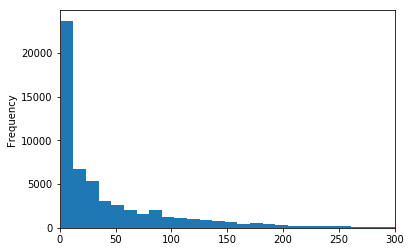

In [33]:
ground_truth["Elements involved"].plot.hist(bins = 98, xlim=[0,300])

Seems like it follows a nice exponnential distribution

In [34]:
def analyseDep(depString):
    """
    Extract interessting numbers about dependances specificaton
    """
    ids = list()
    
    eq = 0
    beq = 0
    leq = 0
    lessThan = 0
    biggerThan = 0
    alternatives = 0
    noSpec = 0
    
    

    for d in depString.split(", "):
        
        alternatives += len(d.split(" | ")) - 1
        
        for d2 in d.split(" | "):

            d2 = d2.split(" (")

            package = d2[0]

            version = ""
            if len(d2) == 2:
                # We have more info about the version
                (req, version) = d2[1][:-1].split(" ")

                if req == "<<" :
                    lessThan +=1 
                    req = "<"
                    
                if req == "<=":
                    leq +=1
                    
                if req == "=":
                    req = "=="
                    eq +=1
                    
                if req == ">=":
                    beq +=1
                    
                if req == ">>":
                    req = ">"
                    biggerThan += 1
            
            else:
                # No info about the version
                noSpec +=1
                
    return lessThan, leq, eq, beq, biggerThan, noSpec, alternatives

ground_truth["<<"], ground_truth["<="], ground_truth["="], ground_truth[">="], ground_truth[">>"], ground_truth["noSpec"], ground_truth["alternatives"] = zip(*ground_truth["Depends"].map(analyseDep))                           

In [35]:
version_spe = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum()
version_spe

<<                4212
<=                  38
=                19854
>=              119179
>>                 513
noSpec           98732
alternatives     10715
dtype: int64

Using percentage we have

In [36]:
total = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().sum()
version_spe = ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().map(lambda x: x/total * 100)
ground_truth[["<<", "<=", "=", ">=", ">>", "noSpec", "alternatives"]].sum().map(lambda x: "{0:.3f}%".format(x/total * 100))


<<               1.663%
<=               0.015%
=                7.840%
>=              47.061%
>>               0.203%
noSpec          38.987%
alternatives     4.231%
dtype: object

##### Visualization of the previous countities

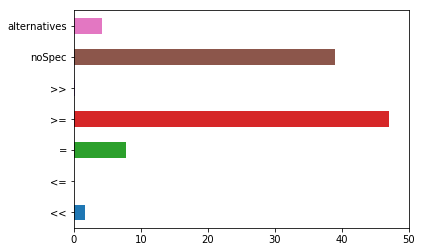

In [37]:
version_spe.plot.barh(x = "percentage", xlim = [0,50])

Here we see that the proportion of `<=` and `>>` is negligible compare to the rest. Indeed, generlly we don't specify that we want strictly higher than a specific version we will rather say this version or higher. Same applies for `<=`, we want stricly less than a specific version in general. 

The vast majority is in `>=` and no spec. 

### Building the dependances trees as a dictionnary

In [ ]:
All_traces = dict()
for index, row in tqdm.tqdm(ground_truth.iterrows()):
    All_traces = {**All_traces, **row['Dependance traces']}
    


In [39]:
All_traces["perl : 5.18.2-2ubuntu1.6"]

{'libbz2-1.0 : 1.0.6-5',
 'libc6 : 2.19-0ubuntu6.14',
 'libdb5.3 : 5.3.28-3ubuntu3.1',
 'libgdbm3 : 1.8.3-12build1',
 'perl-base : 5.18.2-2ubuntu1.6',
 'perl-modules : 5.18.2-2ubuntu1.6',
 'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1'}

In [40]:
All_traces["zlib1g : 1:1.2.8.dfsg-1ubuntu1.1"]

{'libc6 : 2.19-0ubuntu6.14'}

In [41]:
All_traces["libc6 : 2.19-0ubuntu6.14"]

{'libgcc1 : 1:4.9.3-0ubuntu4'}

In [42]:
All_traces['libgcc1 : 1:4.9.3-0ubuntu4']

{'gcc-4.9-base : 4.9.3-0ubuntu4', 'libc6 : 2.19-0ubuntu6.14'}

In [43]:
All_traces["gcc-4.9-base : 4.9.3-0ubuntu4"]

set()

###### Top 5 of Package requiring the most # of dependences

In [44]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances" ]].sort_values("Elements involved", ascending=False).iloc[0:5]

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances
id,,,,,,
29528,kubuntu-full,1.308,2626,{'kubuntu-full : 1.308': {'kde-runtime : 4:4.1...,1109,736776922
9612,kubuntu-full,1.308.1.2,2660,{'kubuntu-full : 1.308.1.2': {'kde-runtime : 4...,1109,736776956
26944,gnome-desktop-environment,1:3.8+4ubuntu3,3130,{'gnome-desktop-environment : 1:3.8+4ubuntu3':...,1080,453541476
26915,gnome,1:3.8+4ubuntu3,2830,{'gnome : 1:3.8+4ubuntu3': {'cheese : 3.10.2-0...,1079,453538346
54490,ubuntu-touch,1.126,2466,{'ubuntu-touch : 1.126': {'qtdeclarative5-qtmu...,1063,405727828


###### Top 5 of Package requiring the most space

In [147]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances" ]].sort_values("Summing dependances", ascending=False).iloc[0:5]

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances
id,,,,,,
11355,texlive-full,2013.20140215-1ubuntu0.1,14542,{'texlive-full : 2013.20140215-1ubuntu0.1': {'...,281,1684150276
53769,texlive-full,2013.20140215-1,14502,{'texlive-full : 2013.20140215-1': {'texlive-f...,281,1684150236
20985,0ad-dbg,0.0.15+dfsg-3,55484348,{'0ad-dbg : 0.0.15+dfsg-3': {'0ad : 0.0.15+dfs...,165,1145821568
25283,flightgear,3.0.0-1,3834076,{'flightgear : 3.0.0-1': {'libglu1-mesa : 9.0....,268,1090723236
20982,0ad,0.0.15+dfsg-3,2561358,{'0ad : 0.0.15+dfsg-3': {'libxml2 : 2.9.1+dfsg...,164,1090337220


Let's group our list by size and by sum of dependances:

#### Most frequent dependences

In [ ]:

for _, row in tqdm.tqdm(ground_truth.iterrows(), total=tot ):
    
    
    d[row.name] = ground_truth["Childrens"].map(lambda childrens: row.name in childrens).sum()

    
s = pd.Series(d, name='Dependence Frequency')
ground_truth = ground_truth.assign( Frequency= s)


In [92]:
ground_truth = ground_truth.assign( Frequency= s)
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Frequency" ]].sort_values(by="Frequency", ascending=False).head(10)

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances,Frequency
id,,,,,,,
751,gcc-4.9-base,4.9.3-0ubuntu4,15146,{'gcc-4.9-base : 4.9.3-0ubuntu4': {}},1,15146,48385
2077,libgcc1,1:4.9.3-0ubuntu4,39194,{'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base ...,3,4806878,48382
1784,libc6,2.19-0ubuntu6.14,4752538,{'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9...,3,4806878,48382
8618,zlib1g,1:1.2.8.dfsg-1ubuntu1.1,49800,{'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 :...,4,4856678,33164
12011,debconf,1.5.51ubuntu2,136156,{'debconf : 1.5.51ubuntu2': {}},1,136156,27592
14027,libbz2-1.0,1.0.6-5,33946,{'libbz2-1.0 : 1.0.6-5': {'libc6 : 2.19-0ubunt...,4,4840824,25507
2826,libpcre3,1:8.31-2ubuntu2.3,144410,{'libpcre3 : 1:8.31-2ubuntu2.3': {'libc6 : 2.1...,4,4951288,22205
2008,libffi6,3.1~rc1+r3.0.13-12ubuntu0.2,17864,{'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2': {'li...,4,4824742,22112
3162,libselinux1,2.2.2-1ubuntu0.1,58690,{'libselinux1 : 2.2.2-1ubuntu0.1': {'libpcre3 ...,5,5009978,21588


In [93]:
ground_truth["Frequency"].describe()

count    56997.000000
mean        50.236030
std        700.517587
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      48385.000000
Name: Frequency, dtype: float64

In [97]:
ground_truth["Freq in %"] = ground_truth["Frequency"].map(lambda x : x/len(ground_truth) )

In [99]:
ground_truth[["Package", "Version", "Size", "Dependance traces","Elements involved","Summing dependances", "Freq in %" ]].sort_values(by="Freq in %", ascending=False).head(10)

,Package,Version,Size,Dependance traces,Elements involved,Summing dependances,Freq in %
id,,,,,,,
751,gcc-4.9-base,4.9.3-0ubuntu4,15146,{'gcc-4.9-base : 4.9.3-0ubuntu4': {}},1,15146,0.848904
2077,libgcc1,1:4.9.3-0ubuntu4,39194,{'libgcc1 : 1:4.9.3-0ubuntu4': {'gcc-4.9-base ...,3,4806878,0.848852
1784,libc6,2.19-0ubuntu6.14,4752538,{'libc6 : 2.19-0ubuntu6.14': {'libgcc1 : 1:4.9...,3,4806878,0.848852
8618,zlib1g,1:1.2.8.dfsg-1ubuntu1.1,49800,{'zlib1g : 1:1.2.8.dfsg-1ubuntu1.1': {'libc6 :...,4,4856678,0.581855
12011,debconf,1.5.51ubuntu2,136156,{'debconf : 1.5.51ubuntu2': {}},1,136156,0.484096
14027,libbz2-1.0,1.0.6-5,33946,{'libbz2-1.0 : 1.0.6-5': {'libc6 : 2.19-0ubunt...,4,4840824,0.447515
2826,libpcre3,1:8.31-2ubuntu2.3,144410,{'libpcre3 : 1:8.31-2ubuntu2.3': {'libc6 : 2.1...,4,4951288,0.389582
2008,libffi6,3.1~rc1+r3.0.13-12ubuntu0.2,17864,{'libffi6 : 3.1~rc1+r3.0.13-12ubuntu0.2': {'li...,4,4824742,0.387950
3162,libselinux1,2.2.2-1ubuntu0.1,58690,{'libselinux1 : 2.2.2-1ubuntu0.1': {'libpcre3 ...,5,5009978,0.378757


In [107]:
f1 = len(ground_truth[ground_truth["Freq in %"] > 0.05])
f2 = len(ground_truth[ground_truth["Freq in %"] > 0.1])
f3 = len(ground_truth[ground_truth["Freq in %"] > 0.15])
f4 = len(ground_truth[ground_truth["Freq in %"] > 0.2])


print("{} Package Involved in more than 5% ".format(f1))
print("{} Package Involved in more than 10% ".format(f2))
print("{} Package Involved in more than 15% ".format(f3))
print("{} Package Involved in more than 20% ".format(f4))

208 Package Involved in more than 5% 
139 Package Involved in more than 10% 
77 Package Involved in more than 15% 
57 Package Involved in more than 20% 


In [8]:
ls

Attack_vizualization.ipynb   cleaned_and_expanded_gt_Final.csv  matching.py
captured_no_dependances.csv  clean_substract_gt.py              packets
cleaned_and_expanded_gt.csv  csv_to_sql.py                      ubuntu_captures


In [3]:
gt = pd.read_csv("../attack/cleaned_and_expanded_gt.csv")
gt = gt.set_index("id")

In [21]:
gt[gt["Elements involved"] == 1]

,Package,Version,Size,Filename,Summing dependances,Elements involved,Childrens,Frequency,Freq in p
id,,,,,,,,,
11665,anthy-common,9100h-23ubuntu2,2505838,pool/main/a/anthy/anthy-common_9100h-23ubuntu2...,2505838.0,1,{11665},15,0.000263
29129,kdepim-doc,4:4.13.0-0ubuntu1,5009690,pool/universe/k/kdepim/kdepim-doc_4.13.0-0ubun...,5009690.0,1,{29129},1,0.000018
17217,libwebkitgtk-1.0-common,2.4.0-1ubuntu2,107038,pool/main/w/webkitgtk/libwebkitgtk-1.0-common_...,107038.0,1,{17217},1,0.000018
53329,sword-text-tr,1.2-0ubuntu2,1275362,pool/universe/s/sword-text-tr/sword-text-tr_1....,1275362.0,1,{53329},1,0.000018
17220,libwebkitgtk-3.0-common,2.4.0-1ubuntu2,106726,pool/main/w/webkitgtk/libwebkitgtk-3.0-common_...,106726.0,1,{17220},1,0.000018
53328,sword-text-swahili,1.1-0ubuntu1,368046,pool/universe/s/sword-text-swahili/sword-text-...,368046.0,1,{53328},1,0.000018
17222,libwebkitgtk-common-dev,2.4.0-1ubuntu2,61680,pool/main/w/webkitgtk/libwebkitgtk-common-dev_...,61680.0,1,{17222},3,0.000053
46727,outdoors-theme,0.1-0ubuntu2,9330,pool/universe/o/outdoors-theme/outdoors-theme_...,9330.0,1,{46727},1,0.000018
39173,libnetbeans-cvsclient-java,6.5-2,348516,pool/universe/n/netbeans-cvsclient/libnetbeans...,348516.0,1,{39173},97,0.001702


<a id=gstreamer></a>
## `The gstreamer1.0-plugins-base`'s Problem
[Table of content](#tc)

#### Problem found while capturing `gstreamer1.0-plugins-base`

On the docker: 

` 
The following NEW packages will be installed:
  gstreamer1.0-plugins-base iso-codes libasound2 libasound2-data
  libcdparanoia0 libdrm-intel1 libdrm-nouveau2 libdrm-radeon1 libelf1
  libgl1-mesa-dri libgl1-mesa-glx libglapi-mesa libglib2.0-0 libglib2.0-data
  libglu1-mesa libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libllvm3.4
  libogg0 liborc-0.4-0 libpciaccess0 libtheora0 libtxc-dxtn-s2tc0
  libvisual-0.4-0 libvisual-0.4-plugins libvorbis0a libvorbisenc2 libx11-6
  libx11-data libx11-xcb1 libxau6 libxcb-dri2-0 libxcb-dri3-0 libxcb-glx0
  libxcb-present0 libxcb-sync1 libxcb1 libxdamage1 libxdmcp6 libxext6
  libxfixes3 libxml2 libxshmfence1 libxxf86vm1 sgml-base shared-mime-info
  xml-core
  0 upgraded, 47 newly installed, 0 to remove and 33 not upgraded.
`

So 47 newly dependences
Much more than what we can see when going through the dep field (19 deps)

In [170]:
ground_truth = load_fingerpatch(dbname ="fingerpatch_old", table="ubuntu_packets")
gt =load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_cleaned_packets")

In [171]:
ground_truth[ground_truth["Package"] == "gstreamer1.0-plugins-base"]["Depends"].iloc[0]

'libc6 (>= 2.14), libcdparanoia0 (>= 3.10.2+debian), libglib2.0-0 (>= 2.37.3), libgstreamer1.0-0 (>= 1.2.0), libogg0 (>= 1.0rc3), liborc-0.4-0 (>= 1:0.4.18), libtheora0 (>= 1.0), libvisual-0.4-0 (>= 0.4.0-4), libvorbis0a (>= 1.1.2), libvorbisenc2 (>= 1.1.2), libgstreamer-plugins-base1.0-0 (>= 1.2.4)'

In [45]:
ground_truth[ground_truth["Package"] == "gstreamer1.0-plugins-base"]["Depends"].iloc[1]

'libc6 (>= 2.14), libcdparanoia0 (>= 3.10.2+debian), libglib2.0-0 (>= 2.37.3), libgstreamer1.0-0 (>= 1.2.0), libogg0 (>= 1.0rc3), liborc-0.4-0 (>= 1:0.4.18), libtheora0 (>= 1.0), libvisual-0.4-0 (>= 0.4.0-4), libvorbis0a (>= 1.1.2), libvorbisenc2 (>= 1.1.2), libgstreamer-plugins-base1.0-0 (>= 1.2.4)'

In [39]:
ground_truth[ground_truth["Package"] == "gstreamer1.0-plugins-base"]["Depends"].iloc[1]

'libc6 (>= 2.14), libcdparanoia0 (>= 3.10.2+debian), libglib2.0-0 (>= 2.37.3), libgstreamer1.0-0 (>= 1.2.0), libogg0 (>= 1.0rc3), liborc-0.4-0 (>= 1:0.4.18), libtheora0 (>= 1.0), libvisual-0.4-0 (>= 0.4.0-4), libvorbis0a (>= 1.1.2), libvorbisenc2 (>= 1.1.2), libgstreamer-plugins-base1.0-0 (>= 1.2.4)'

In [78]:
ground_truth[ground_truth["Package"] == "libgstreamer-plugins-base1.0-0"]["Depends"].iloc[0]

'libc6 (>= 2.14), libglib2.0-0 (>= 2.37.3), libgstreamer1.0-0 (>= 1.2.0), liborc-0.4-0 (>= 1:0.4.18), zlib1g (>= 1:1.1.4), iso-codes'

In [56]:
ground_truth[ground_truth["Package"] == "libgcc1"]["Depends"].iloc[0]

'gcc-4.9-base (= 4.9-20140406-0ubuntu1), libc6 (>= 2.14)'

In [62]:
ground_truth[ground_truth["Package"] == "gcc-4.9-base"]["Depends"]

id
1152     
45633    
Name: Depends, dtype: object

In [16]:
ground_truth[ground_truth["Package"] == "libglib2.0-0"]["Depends"].iloc[1]

'libc6 (>= 2.17), libffi6 (>= 3.0.4), libpcre3, libselinux1 (>= 1.32), zlib1g (>= 1:1.2.2)'

In [83]:
parseAndFindDep(ground_truth[ground_truth["Package"] == "libffi6"]["Depends"].iloc[0], ground_truth)

[174814]

In [173]:
childrens = gt[gt["Package"] == "gstreamer1.0-plugins-base"]["Childrens"].iloc[0]

In [176]:
gt.loc[list(childrens)]["Package"].tolist()

['libvorbis0a',
 'libvorbisenc2',
 'libselinux1',
 'libvisual-0.4-0',
 'libpcre3',
 'gstreamer1.0-plugins-base',
 'zlib1g',
 'libgstreamer-plugins-base1.0-0',
 'gcc-4.9-base',
 'libgstreamer1.0-0',
 'libogg0',
 'libtheora0',
 'liborc-0.4-0',
 'libffi6',
 'libc6',
 'libglib2.0-0',
 'libcdparanoia0',
 'libgcc1',
 'iso-codes']

In [177]:
len(childrens)

19

But using `apt-cache depends gstreamer1.0-plugins-base` in the docker will lead us to understand why we found 19 and not 47. 

We see that there are not only fields `Depends` but also `Recommends`, `Suggests`, `Pre-Depends`, `Breaks`, ect...

    `Depends`    -> Absolute dependency
    `Pre-Depends`-> Like Depends but even stronger (tell dpkg to install it before)
    `Recommends` -> Strong dependency download enabled by default |--no-install-recommend
    `Suggests`   -> disabled by default |--install-suggests
    
Since our table only contains the absolute dependences, and our docker install the recommends Packages by default, we are missing some packages.

By running `apt-get install --no-install-recommend gstreamer1.0-plugins-base` we get:

`
The following extra packages will be installed:
  iso-codes libcdparanoia0 libglib2.0-0 libgstreamer-plugins-base1.0-0
  libgstreamer1.0-0 libogg0 liborc-0.4-0 libtheora0 libvisual-0.4-0
  libvorbis0a libvorbisenc2
Suggested packages:
  gvfs isoquery libvisual-0.4-plugins gstreamer-codec-install
  gnome-codec-install gstreamer1.0-tools
Recommended packages:
  libglib2.0-data shared-mime-info
The following NEW packages will be installed:
  gstreamer1.0-plugins-base iso-codes libcdparanoia0 libglib2.0-0
  libgstreamer-plugins-base1.0-0 libgstreamer1.0-0 libogg0 liborc-0.4-0
  libtheora0 libvisual-0.4-0 libvorbis0a libvorbisenc2
0 upgraded, 12 newly installed, 0 to remove and 37 not upgraded.
Need to get 5300 kB of archives.
`

    
More [here](
https://www.debian.org/doc/debian-policy/ch-relationships.html)

<a id='kernels'></a>
## Kernel Packages

Here we are having a close look about the Kernel Package.

More infos [here](https://askubuntu.com/questions/266772/why-are-there-so-many-linux-kernel-packages-on-my-machine-and-what-do-they-a)

[table of content](#tc)

In [337]:
# Load the cleaned db
gt =load_fingerpatch("ubuntu_cleaned_packets")
gt_old =load_fingerpatch(dbname="fingerpatch_old", table="ubuntu_cleaned_packets")

In [338]:
kernel_keyword = gt_old[gt_old.Package.str.contains("kernel-")]
lin_im = gt_old[gt_old.Package.str.contains("linux-image")]
print("Old db : " + str(len(kernel_keyword))+ " Packages containing `kernel-` key words")
print("Old db : " +str(len(lin_im)) + " Packages containing `linux-image` key words")

# We concatenate both of them
kernel_package = pd.concat([kernel_keyword, lin_im])

kernel_keyword = gt[gt.Package.str.contains("kernel-")]
lin_im = gt[gt.Package.str.contains("linux-image")]
print("\nNew db : " + str(len(kernel_keyword))+ " Packages containing `kernel-` key words")
print("New db : " + str(len(lin_im))+ " Packages containing `linux-image` key words")

# We concatenate both of them
kernel_package = pd.concat([kernel_keyword, lin_im])

Old db : 14 Packages containing `kernel-` key words
Old db : 774 Packages containing `linux-image` key words

New db : 14 Packages containing `kernel-` key words
New db : 778 Packages containing `linux-image` key words


In [339]:
kernel_package.sample(50)[["Package", "Version", "Size","Summing dependances" ,"Elements involved"]]

,Package,Version,Size,Summing dependances,Elements involved
id,,,,,
178594,linux-image-extra-3.13.0-160-generic,3.13.0-160.210,37081418,58936950,20
178267,linux-image-3.16.0-26-lowlatency,3.16.0-26.35~14.04.1,53687552,66764432,54
178078,linux-image-3.13.0-100-generic,3.13.0-100.147,15322978,28399858,54
178084,linux-image-3.13.0-105-generic,3.13.0-105.152,15268528,28345408,54
178420,linux-image-4.2.0-22-generic,4.2.0-22.27~14.04.1,17152844,30229724,54
178819,linux-image-virtual-lts-wily,4.2.0.42.34,2298,30307144,55
178444,linux-image-4.4.0-103-generic,4.4.0-103.126~14.04.1,20903094,33979974,54
178210,linux-image-3.13.0-58-generic,3.13.0-58.97,15213244,28290124,54
178732,linux-image-extra-4.2.0-36-generic,4.2.0-36.42~14.04.1,38366786,69570144,60


50 Randomly chosen Package name

In [340]:
kernel_package.describe()


,Size,Summing dependances,Elements involved,Frequency,Freq in p
count,7.920000e+02,7.920000e+02,792.000000,792.000000,792.0
mean,3.342112e+07,5.477547e+07,52.323232,2.248737,0.0
std,1.720060e+07,2.037022e+07,12.816277,3.187364,0.0
min,1.754000e+03,6.362000e+03,1.000000,1.000000,0.0
25%,1.673806e+07,3.024990e+07,54.000000,1.000000,0.0
50%,3.674342e+07,6.511366e+07,54.000000,2.000000,0.0
75%,5.190540e+07,6.858892e+07,60.000000,3.000000,0.0
max,5.736519e+07,1.064856e+08,104.000000,60.000000,0.0


In [341]:
gt.describe()

,Size,Summing dependances,Elements involved,Frequency,Freq in p
count,5.712500e+04,5.712500e+04,57125.000000,57125.000000,57125.000000
mean,2.118439e+06,2.304105e+07,50.181129,50.181129,0.000070
std,1.650300e+07,4.103973e+07,75.683623,700.790561,0.008368
min,7.960000e+02,1.542000e+03,1.000000,1.000000,0.000000
25%,1.605600e+04,5.330682e+06,6.000000,1.000000,0.000000
50%,6.317800e+04,1.302607e+07,20.000000,1.000000,0.000000
75%,3.928900e+05,2.374324e+07,63.000000,3.000000,0.000000
max,1.067972e+09,1.687585e+09,1109.000000,48476.000000,1.000000


In average, the kernel packages are approximatively 10 times bigger

Not a lot of variation in the distribution of the elements involved, which is approximatively the overall mean: 53 elements involved per packages

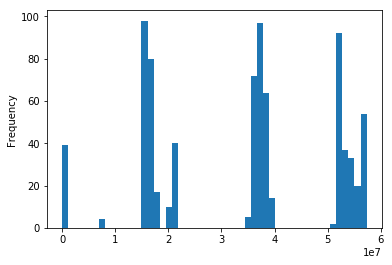

In [342]:
lin_im.Size.plot.hist(bins = 50)

##### COMPARING w.r.t their dependences #####

In [343]:
lin_im["Elements involved"].describe()

count    778.000000
mean      52.511568
std       11.851744
min       14.000000
25%       54.000000
50%       54.000000
75%       60.000000
max       66.000000
Name: Elements involved, dtype: float64

In [344]:
gt["Elements involved"].describe()

count    57125.000000
mean        50.181129
std         75.683623
min          1.000000
25%          6.000000
50%         20.000000
75%         63.000000
max       1109.000000
Name: Elements involved, dtype: float64

In [345]:
g = kernel_package.groupby("Size").count()
g.groupby("Package").count()

,Version,Filename,Summing dependances,Elements involved,Childrens,Frequency,Freq in p
Package,,,,,,,
1,773,773,773,773,773,773,773
2,7,7,7,7,7,7,7
5,1,1,1,1,1,1,1


In [346]:
uniqueness_count = []

# For each kernel package we count the nuber of other packages that have the same size
for index, row in kernel_package.iterrows():
    uniqueness_count += [len(gt[gt["Size"] == row['Size']])]

In [349]:
from collections import Counter
cnt = Counter()

# Just count how many kernel packages have the same number of other packages exact size
for x in uniqueness_count:
    cnt[x] +=1

# Sum of occurences of unique sized Packages
total =0
for x, y in cnt.items():
    total +=  y

# Translating into percentage
for x, y in cnt.items():
    print("#unique: ",x, " at ", y/total, " %" )

#unique:  1  at  0.9494949494949495  %
#unique:  3  at  0.010101010101010102  %
#unique:  2  at  0.005050505050505051  %
#unique:  4  at  0.006313131313131313  %
#unique:  5  at  0.003787878787878788  %
#unique:  39  at  0.0025252525252525255  %
#unique:  46  at  0.0025252525252525255  %
#unique:  34  at  0.006313131313131313  %
#unique:  6  at  0.006313131313131313  %
#unique:  41  at  0.0012626262626262627  %
#unique:  17  at  0.0025252525252525255  %
#unique:  10  at  0.0012626262626262627  %
#unique:  9  at  0.0012626262626262627  %
#unique:  7  at  0.0012626262626262627  %


We see that most of the Package Kernel are unique in size against the whole dataframe i.e. : 95%

In [348]:
cnt

Counter({1: 752,
         3: 8,
         2: 4,
         4: 5,
         5: 3,
         39: 2,
         46: 2,
         34: 5,
         6: 5,
         41: 1,
         17: 2,
         10: 1,
         9: 1,
         7: 1})

 <a id = "time_changement"></a>
## Time Changement On Crawled Packages
[Table of content](#tc)

After a period of approximatively 1 month.

In [206]:
gt=load_fingerpatch("ubuntu_cleaned_packets")
gt_old=load_fingerpatch("ubuntu_cleaned_packets", "fingerpatch_old")

In [207]:
print("{} more Packages ".format(gt.count().iloc[0] - gt_old.count().iloc[0]))
added_size = gt["Size"].sum() - gt_old["Size"].sum()
print("overall size has been expanded by {}".format(added_size))

128 more Packages 
overall size has been expanded by 1006343270


Now we can have a closer look of what have been changed



In [209]:
gt["Package_Version"] = gt.apply( lambda x:  x["Package"] +" "+x["Version"] , axis = 1)
gt_old["Package_Version"] = gt_old.apply( lambda x:  x["Package"] +" "+x["Version"] , axis = 1)

gt = gt.set_index(["Package_Version"])
gt_old = gt_old.set_index(["Package_Version"])

In [211]:
print("Make sure that both df have unique index to compare them proprely: {} | {}".format(gt.index.is_unique,gt_old.index.is_unique))

Make sure that both df have unique index to compare them proprely: True | True


No we want to see what new packages have been added

All the new packages that have been added versus all the old packages that have been removed

In [212]:
new = gt.index.difference(gt_old.index)
new

Index(['apparmor 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-docs 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-easyprof 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-notify 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-profiles 2.10.95-0ubuntu2.6~14.04.4',
       'apparmor-utils 2.10.95-0ubuntu2.6~14.04.4', 'apturl 0.5.2ubuntu4.1',
       'apturl-common 0.5.2ubuntu4.1', 'apturl-kde 0.5.2ubuntu4.1',
       'audiofile-tools 0.3.6-2ubuntu0.14.04.3',
       ...
       'vigor 0.016-24build0.14.04.1', 'wireshark 2.6.3-1~ubuntu14.04.1',
       'wireshark-common 2.6.3-1~ubuntu14.04.1',
       'wireshark-dev 2.6.3-1~ubuntu14.04.1',
       'wireshark-doc 2.6.3-1~ubuntu14.04.1',
       'wireshark-gtk 2.6.3-1~ubuntu14.04.1',
       'wireshark-qt 2.6.3-1~ubuntu14.04.1',
       'xul-ext-calendar-timezones 1:60.2.1+build1-0ubuntu0.14.04.2',
       'xul-ext-gdata-provider 1:60.2.1+build1-0ubuntu0.14.04.2',
       'xul-ext-lightning 1:60.2.1+build1-0ubuntu0.14.04.2'],
      dtype='object', name='Pac

In [213]:
old = gt_old.index.difference(gt.index)
old

Index(['apparmor 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-docs 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-docs 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-easyprof 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-easyprof 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-notify 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-notify 2.10.95-0ubuntu2.6~14.04.3',
       'apparmor-profiles 2.10.95-0ubuntu2.6~14.04.1',
       'apparmor-profiles 2.10.95-0ubuntu2.6~14.04.3',
       ...
       'tshark 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'tzdata 2018e-0ubuntu0.14.04', 'tzdata-java 2018e-0ubuntu0.14.04',
       'wireshark 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'wireshark-common 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'wireshark-dev 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'wireshark-qt 1.12.1+g01b65bf-4+deb8u11ubuntu0.14.04.1',
       'xul-ext-calendar-timezones 1:52.9.1+build3-0ubuntu0.14.04.1',
       'x

Is there any packages are not updated in version put only on siz?

In [214]:
# Size added by the new Packages - Size substracted by the old packages
gt.loc[new].Size.sum() - gt_old.loc[old].Size.sum()

1006343270

Same has the total sum added : __Only new Packages Influences the Size__

 <a id ="unicity"></a>
## Unicity
Exploring how unique are the size in the whole ground-truth dataframe

[Table of Content](#tc)

In [216]:
gt=load_fingerpatch("ubuntu_cleaned_packets")
gt["Freq in p"] =gt["Frequency"].map(lambda x : x/len(gt))

In [217]:
# We groupby Size and count the number of occurences and group again on that number of occurences
bySize = gt.groupby(by="Size").count().groupby(by = "Package").count()

# Useful for %tage
total = bySize["Version"].sum()


# Convert the number of occurence to a percentage
unicity_1 =bySize["Version"].map(lambda x : x/total).sort_values(ascending = False).head(5)

# Similar step as above
includingDep = gt.groupby(by="Summing dependances").count().groupby(by = "Package").count()
total = includingDep["Version"].sum()
unicity_2 = includingDep["Version"].map(lambda x : x/total).sort_values(ascending = False).head(5)

In [291]:
# Get the Packages that are present in at least TOP_X of the package's childrens
TOP_X = 0.2
most_common_dep = gt[gt["Freq in p"] >=TOP_X]
print("The packages that are at least in "+str(TOP_X*100)+"% of other Packages ")
gt.loc[most_common_dep.index]["Package"]

The packages that are at least in 20.0% of other Packages 


id
128845               debconf
128853           debianutils
129182     fonts-dejavu-core
130723       libaudit-common
130725             libaudit1
130861            libbz2-1.0
131808         libgpg-error0
132150              libjpeg8
132331              liblzma5
132641          libncursesw5
132819           libp11-kit0
133495    libsemanage-common
133496          libsemanage1
133832             libtinfo5
133954         libustr-1.0-1
134166               libxau6
134257               libxcb1
134270             libxdmcp6
136546                   ucf
173482             coreutils
173545                  dpkg
173738     fontconfig-config
173770          gcc-4.8-base
173781          gcc-4.9-base
174814                 libc6
174862            libcomerr2
174900              libdb5.3
174914           libdbus-1-3
175035             libexpat1
175038               libffi6
175046        libfontconfig1
175061          libfreetype6
175107               libgcc1
175118           libgcrypt11
175264     

In [281]:
def create_unicity_df_from_top_most_common(TOP_X, df):
    
    # Get the Packages that are present in at least TOP_X of the package's childrens
    most_common_dep = gt[gt["Freq in p"] >=TOP_X]
    
    # Creating a dict to get the size from the id of the most common packages
    mst_comm_dep = most_common_dep["Size"]
    mst_comm_dep_dict = mst_comm_dep.to_dict()

    # Removing the most common packages in the dataframe
    gt_without_mcd = df.drop(mst_comm_dep.index)

    # Function to substract the Size of the most common Packages
    def substract_comm(row, mst_comm_dep_dict):
        s = row["Summing dependances"]
        for c in row["Childrens"]:
            if c in mst_comm_dep_dict :

                s = s - mst_comm_dep_dict[c]

        return s


    sum_size_without_common =gt_without_mcd.apply(lambda x : substract_comm(x, mst_comm_dep_dict), 1)

    # Same has unicity_1 & 2
    grp = sum_size_without_common.groupby(sum_size_without_common).count()
    unicity = grp.groupby(grp).count()
    unicity =unicity.map(lambda x :x/unicity.sum()).sort_values(ascending = False).head(5)
    return unicity

unicity_3 = create_unicity_df_from_top_most_common(TOP_X, gt)

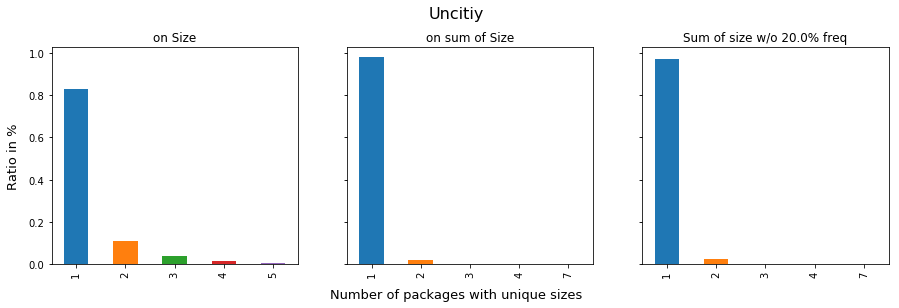

In [285]:
## Plotting the 3 graphs

def create_unicity_plot(unicity_1, unicity_2, unicity_3, t1, t2, t3):
    fig, ax =plt.subplots(1, 3, sharey=True, figsize=(15, 4))
    fig.suptitle("Uncitiy", fontsize=16, y=1.02)

    # Graph on size
    ax[0].set_title(t1)
    unicity_1.plot.bar(ax = ax[0])
    ax[0].xaxis.set_label_text('')

    # Graph on sum of Size
    ax[1].set_title(t2)
    unicity_2.plot.bar(ax = ax[1])
    ax[1].xaxis.set_label_text('')

    ax[2].set_title(t3)
    unicity_3.plot.bar(ax =ax[2])
    fig.text(0.5, 0.02, 'Number of packages with unique sizes',fontsize=13 ,ha='center', va='center')

    fig.text(0.09, 0.5, 'Ratio in %', ha='center', va='center',fontsize=13, rotation='vertical')

    
create_unicity_plot(unicity_1, unicity_2, unicity_3, "on Size","on sum of Size", "Sum of size w/o "+str(TOP_X*100)+"% freq" )

Reducing this `TOP_X` value, we can get closer than the first graph 

In [325]:
gt["Freq in p"].min()

1.75054704595186e-05

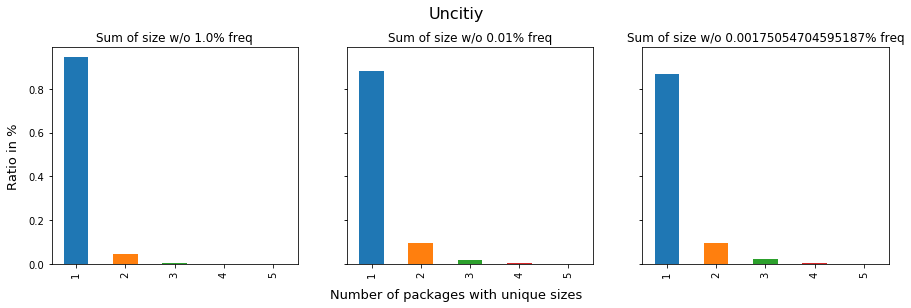

In [330]:
low = 0.01
very_low = 0.0001
lowest = 1.75054704595187e-05

unicity_lowest = create_unicity_df_from_top_most_common(lowest, gt)
unicity_low = create_unicity_df_from_top_most_common(low, gt)
unicity_very_low = create_unicity_df_from_top_most_common(very_low, gt)


t_low ="Sum of size w/o "+str(low*100)+"% freq"
t_very_low ="Sum of size w/o "+str(very_low*100)+"% freq"
t_lowest = "Sum of size w/o "+str(lowest*100)+"% freq"

create_unicity_plot(unicity_low, unicity_very_low, unicity_lowest, t_low, t_very_low, t_lowest)

In [265]:
print("---Size--- \n\n",unicity_1, "\n\n---Summing dep---\n\n", unicity_2, "\n\n--Sum w/o "+ str(TOP_X*100)+"% common--- \n\n", unicity_3, "\n")

---Size--- 

 Package
1    0.830332
2    0.111081
3    0.035878
4    0.012576
5    0.004930
Name: Version, dtype: float64 

---Summing dep---

 Package
1    0.981282
2    0.017575
3    0.000875
4    0.000196
7    0.000054
Name: Version, dtype: float64 

--Sum w/o 50.0% common--- 

 1    0.977398
2    0.021041
3    0.001256
4    0.000233
7    0.000054
dtype: float64 



In [328]:
print("---Low--- \n\n",unicity_low, "\n\n---Very_Low---\n\n", unicity_very_low, "\n\n--- Lowest--- \n\n", unicity_lowest, "\n")

---Low--- 

 1    0.944723
2    0.047894
3    0.006253
4    0.000923
5    0.000132
dtype: float64 

---Very_Low---

 1    0.878596
2    0.094940
3    0.018823
4    0.004730
5    0.001552
dtype: float64 

--- Lowest--- 

 1    0.867167
2    0.097486
3    0.021689
4    0.005553
5    0.002552
dtype: float64 



In [95]:
both = ground_truth["Size"].append(ground_truth["Summing dependances"])
grouped = both.groupby(both).count()
uniqueness = grouped.groupby(grouped).count().sort_values(ascending = False)
total = uniqueness.sum()
uniqueness.map(lambda x : x/total).head()

1    0.856584
2    0.106516
3    0.022322
4    0.008270
5    0.003207
dtype: float64

<a id = "signatures"></a>
## Signatures in apt

[Table of contents](#tc)

Great overview [here](https://debian-handbook.info/browse/stable/sect.package-authentication.html) of how are managed package's signatrue

The key's are managed by `apt-key` and used to verify the signature in the __Release__ file where all the packages metadata are contained with their respectives sha256 and md5 to which in trun verify the integrity and authenticity of a downloaded package.

The Release file is in `var/lib/apt/lists`